# 06 — Fine Tuning und Robustheit

## Ziel
Dieses Notebook beschreibt den Prozess der Feinabstimmung unseres Modells und die Bewertung seiner Robustheit gegenüber verschiedenen Störungen in den Eingabedaten.

In [1]:
import sys, importlib

# reload in der richtigen Reihenfolge (dependencies zuerst, dann consumer)
for m in [
    "utils.models.artist_clustering",
    "utils.models.artist_trajectory",
    "utils.models.hit",
    "utils.models.moods",
    "utils.models.ranker",
    "utils.models.success_pct",
    "utils.models.success_residual",
    "utils.models.track_similarity",


]:
    if m in sys.modules:
        importlib.reload(sys.modules[m])

## Imports und Setup

In [2]:
import importlib
import numpy as np

import utils.core.paths as paths
from utils.data.training_data_loader import load_all
from utils.reporting.reporting import save_joblib, save_json
from utils.config.settings import RANDOM_SEED, ALLOW_LEAKY_FEATURES

# Import modules (NOT classes) so reload works
import utils.models.success_pct as success_pct
import utils.models.success_residual as success_residual
import utils.models.hit as hit
import utils.models.moods as moods
import utils.models.ranker as ranker
import utils.models.artist_trajectory as artist_trajectory
import utils.models.artist_clustering as artist_clustering
import utils.models.track_similarity as track_similarity

# Reload modules
importlib.reload(success_pct)
importlib.reload(success_residual)
importlib.reload(hit)
importlib.reload(moods)
importlib.reload(ranker)
importlib.reload(artist_trajectory)
importlib.reload(artist_clustering)
importlib.reload(track_similarity)

# Keep references to CLASSES (optional)
SuccessPctTrainer = success_pct.SuccessPctTrainer
SuccessResidualTrainer = success_residual.SuccessResidualTrainer
HitTrainer = hit.HitTrainer
MoodTrainer = moods.MoodTrainer
RankerTrainer = ranker.RankerTrainer
ArtistTrajectoryTrainer = artist_trajectory.ArtistTrajectoryTrainer
ArtistClusteringRunner = artist_clustering.ArtistClusteringRunner
TrackSimilarityRunner = track_similarity.TrackSimilarityRunner

from utils.data.datasets import (
    build_success_pct_dataset,
    build_success_residual_dataset,
    build_hit_dataset,
    build_mood_dataset,
)

# Reload paths if you need
importlib.reload(paths)

SAMPLE_NAME = paths.load_sample_name()
PATHS = paths.make_paths(SAMPLE_NAME)
paths.ensure_dirs(PATHS)




## Load Data

In [3]:
data = load_all(PATHS.input_targets_path)

ds_pct  = build_success_pct_dataset(data.X_track, data.track_df, data.y_success_pct)
ds_res  = build_success_residual_dataset(data.X_track, data.track_df, data.y_success_residual)
ds_hit  = build_hit_dataset(data.X_track, data.track_df, data.y_hit)
ds_mood = build_mood_dataset(data.X_track, data.track_df, data.Y_mood)

ap = data.artist_panel.sort_values("release_month_ts").reset_index(drop=True)

y_artist_growth = ap["y_growth"].astype(float)
y_artist_breakout = ap["y_breakout"].astype(int)

X_artist_panel = ap.select_dtypes(include=["number", "bool"]).drop(
    columns=["y_growth", "y_breakout", "release_month_ts", "artist_id"],
    errors="ignore"
).fillna(0)



## Tuning: Success Percentile innerhalb der Kohorte (Regression)

Ziel: Vorhersage der relativen Erfolgsposition eines Tracks innerhalb seiner Release-Kohorte (0–100).

Optimierungsziel:
- **MAE auf dem Validierungsset minimieren**, da die Skala interpretierbar ist (Punkte im Perzentilraum).

Hinweis:
- Wir nutzen einen **kohortenbasierten Zeitsplit**, um Leakage in die Zukunft zu vermeiden.
- Optional kann XGBoost auf **GPU (CUDA)** laufen (`device="cuda"`).


In [5]:
pct_trainer = SuccessPctTrainer(seed=RANDOM_SEED)

best_pct = pct_trainer.tune(
    ds_pct,
    n_trials=20,
    device="gpu",   # oder "cpu"
)

best_pct

C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'learning_rate': 0.014667957682359355,
  'max_depth': 6,
  'min_child_weight': 6.292922406082994,
  'max_leaves': 76,
  'subsample': 0.6043724887456259,
  'colsample_bytree': 0.8756241024299656,
  'reg_lambda': 33.906855824038054,
  'reg_alpha': 0.011937234006750072,
  'gamma': 1.9138986725502336},
 'best_val_mae': 20.292547236118068,
 'best_iteration': 6028,
 'metric_name': 'mae',
 'direction': 'minimize',
 'n_trials': 20,
 'study_name': 'success_pct_tuning',
 'extra_metrics': {'best_rmse_across_trials': 24.68459392730989,
  'best_trial_r2': 0.2614720574208863},
 'device': 'gpu'}

## Tuning: Success Residual innerhalb der Kohorte (Regression)

Ziel: Modellierung von **Über- oder Unterperformance** relativ zur Kohorte (Residual statt absoluter Erfolg).

Optimierungsziel:
- **MAE auf dem Validierungsset minimieren** (robust, gut interpretierbar).

Hinweis:
- Residual-Targets sind oft verrauscht → Regularisierung ist besonders wichtig.
- Kohortenbasierter Zeitsplit verhindert ungewollte Zukunftsinformation.


In [6]:
res_trainer = SuccessResidualTrainer(seed=RANDOM_SEED)

best_res = res_trainer.tune(
    ds_res,
    n_trials=20,
    device="cuda",   # oder "cpu"
)

best_res



C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'learning_rate': 0.06907077625237132,
  'max_depth': 7,
  'min_child_weight': 32.115555656190736,
  'max_leaves': 106,
  'subsample': 0.6128555477357835,
  'colsample_bytree': 0.6994258053538001,
  'reg_lambda': 6.705095902750748,
  'reg_alpha': 0.25756615252278653,
  'gamma': 1.7159284774735706},
 'best_val_mae': 10.119166374206543,
 'best_iteration': 1647,
 'metric_name': 'mae',
 'direction': 'minimize',
 'n_trials': 20,
 'study_name': 'success_residual_tuning',
 'extra_metrics': {'best_r2_across_trials': 0.22147828340530396,
  'best_trial_rmse': 14.398760191209009,
  'best_trial_r2': 0.22147828340530396},
 'device': 'cuda'}

## Tuning: Hit Prediction (Binary Classification)

Ziel: Vorhersage, ob ein Track als „Hit“ gilt.

Optimierungsziel:
- **PR-AUC auf dem Validierungsset maximieren**
  (bei unausgeglichenen Klassen oft sinnvoller als ROC-AUC).

Zusatz:
- Der finale **Threshold** (für F1) wird später auf der Validierung optimiert (wie im Training-Notebook).
- GPU ist möglich (XGBoost).


In [7]:
hit_trainer = HitTrainer(seed=RANDOM_SEED)

best_hit = hit_trainer.tune(
    ds_hit,
    n_trials=30,
    device="cuda",   # oder "cpu"
)

best_hit


C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'learning_rate': 0.022076756171173464,
  'max_depth': 7,
  'min_child_weight': 27.159118082276926,
  'max_leaves': 83,
  'subsample': 0.8329944857876966,
  'colsample_bytree': 0.659592578108193,
  'reg_lambda': 5.415015993946293,
  'reg_alpha': 0.14864298767380946,
  'gamma': 0.6012129031399405,
  'scale_pos_weight': 7.123635294165483,
  'max_delta_step': 1},
 'best_val_pr_auc': 0.42528660928241074,
 'best_iteration': 794,
 'metric_name': 'pr_auc',
 'direction': 'maximize',
 'n_trials': 30,
 'study_name': 'hit_prediction_tuning',
 'extra_metrics': {'best_f1_across_trials': 0.47629310344827586,
  'best_f1_threshold': 0.65,
  'best_f1_trial': 18,
  'class_imbalance_ratio': 8.660873932697138},
 'device': 'cuda'}

## Tuning: Mood Prediction (Multi-Label)

Ziel: Mehrere Mood-Labels pro Track (z.B. happy, sad, chill …).

Optimierungsziel:
- **Micro-F1 auf dem Validierungsset maximieren**
  (gute Standardmetrik bei Multi-Label, weil sie alle Entscheidungen gemeinsam bewertet).

Hinweis:
- Viele sklearn-Modelle laufen CPU-basiert; GPU ist hier meistens nicht relevant.
- Thresholds können später pro Label separat optimiert werden.


In [8]:
mood_trainer = MoodTrainer(seed=RANDOM_SEED)

best_mood = mood_trainer.tune(
    ds_mood,
    n_trials=60,
)

best_mood


C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'penalty': 'l1',
  'alpha': 0.009924895701694794,
  'loss': 'log_loss',
  'threshold': 0.3192517185672371},
 'best_val_micro_f1': 0.6666666666666666,
 'best_iteration': None,
 'metric_name': 'micro_f1',
 'direction': 'maximize',
 'n_trials': 60,
 'study_name': 'mood_multilabel_tuning',
 'extra_metrics': {'best_macro_f1_across_trials': 0.6793499248869252,
  'best_trial_macro_f1': 0.6736185003355357,
  'best_threshold': 0.3192517185672371,
  'micro_macro_ratio': 0.9896798652866476,
  'n_labels': 7},
 'device': 'cpu'}

## Tuning: Ranker (Learning-to-Rank)

Ziel: Tracks innerhalb einer Kohorte sinnvoll zu ranken (Top-K Qualität).

Optimierungsziel:
- **Mean NDCG@10 auf dem Validierungsset maximieren**.

Wichtig:
- Ranking benötigt eine saubere Gruppierung (z.B. pro `cohort_ym`).
- GPU ist möglich (XGBRanker).


In [9]:
rank_trainer = RankerTrainer(seed=RANDOM_SEED)

best_rank = rank_trainer.tune(
    ds_pct,        # typischerweise nutzt der Ranker das gleiche X, aber anderes Training/Grouping
    n_trials=30,
    device="cuda", # oder "cpu"
    k=10
)

best_rank


C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'learning_rate': 0.07459965814054327,
  'max_depth': 5,
  'min_child_weight': 38.471725972222664,
  'max_leaves': 121,
  'subsample': 0.6180127430819794,
  'colsample_bytree': 0.7288407907827336,
  'reg_lambda': 18.476582520431815,
  'reg_alpha': 1.5244204965288453,
  'gamma': 0.665315248447172},
 'best_val_ndcg@10': 0.3896646464884345,
 'best_iteration': 31,
 'metric_name': 'ndcg@10',
 'direction': 'maximize',
 'n_trials': 30,
 'study_name': 'ranker_tuning',
 'extra_metrics': {'k': 10,
  'n_groups_train': 961,
  'n_groups_val': 3,
  'relevance_bins': 5},
 'device': 'cuda'}

## Tuning: Artist Trajectory (Growth & Breakout)

Ziel: Künstlerentwicklung über Zeit modellieren.

Teilaufgaben:
- **Growth (Regression):** log1p-transformiertes Wachstum → **MAE minimieren**
- **Breakout (Binary):** Breakout-Event → **PR-AUC maximieren**

Hinweis:
- Zeitliche Sortierung ist Pflicht, damit der Split korrekt ist.
- GPU ist möglich (XGBoost).


In [10]:
artist_trainer = ArtistTrajectoryTrainer(seed=RANDOM_SEED)

best_artist = artist_trainer.tune(
    data.artist_panel,
    n_trials=30,
    device="cuda",   # oder "cpu"
)

best_artist


C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'growth': {'best_params': {'learning_rate': 0.01058351721163647,
   'max_depth': 7,
   'min_child_weight': 19.016037699375463,
   'max_leaves': 78,
   'subsample': 0.6912435140379218,
   'colsample_bytree': 0.8600144799499261,
   'reg_lambda': 4.99781259730103,
   'reg_alpha': 0.17674003133519878,
   'gamma': 1.6003384871494437},
  'best_val_mae': 0.02192936836466202,
  'best_iteration': 19999,
  'metric_name': 'mae',
  'direction': 'minimize',
  'n_trials': 15,
  'study_name': 'artist_trajectory_growth',
  'extra_metrics': {'best_r2_across_trials': 0.9967447135633732,
   'best_trial_rmse': 0.05844995333491596,
   'target_transform': 'log1p'},
  'device': 'cuda'},
 'breakout': {'best_params': {'learning_rate': 0.041563964020544394,
   'max_depth': 6,
   'min_child_weight': 6.959275467205035,
   'max_leaves': 35,
   'subsample': 0.7551822356084219,
   'colsample_bytree': 0.7691471714522385,
   'reg_lambda': 1.0702093991631996,
   'reg_alpha': 1.5731025761564534,
   'gamma': 1.612124835

## Tuning: Artist Clustering (KMeans, Unüberwacht)

Ziel: Gruppierung von Künstlern basierend auf numerischen Features (ohne Ground Truth).

Optimierungsziel:
- **Silhouette-Score auf dem Sample maximieren** (misst Cluster-Trennung, Bereich [-1, 1]).

Sekundäre Metrik:
- **Davies-Bouldin-Index** (niedriger = kompaktere, besser getrennte Cluster).

Suchraum:
- `k`: Anzahl Cluster (10–50)
- `pca_dim`: PCA-Dimensionen vor Clustering (8–16)

Hinweis:
- Wir tunen auf einem **Sample** (8000 Artists) für schnellere Evaluierung.
- Das finale Modell wird auf dem **vollständigen Datensatz** trainiert.
- Optional: 2D-PCA-Visualisierung zur qualitativen Prüfung.


In [11]:
RNG = np.random.RandomState(RANDOM_SEED)

# Sample Artists für schnellere Evaluierung während Tuning
sample_n = 8000
idx = RNG.choice(len(data.artist_df), size=sample_n, replace=False)
artist_sample = data.artist_df.iloc[idx].copy()

# Tuning mit Optuna (Silhouette-Score maximieren)
cluster_tuner = ArtistClusteringRunner(seed=RANDOM_SEED)

best_cluster = cluster_tuner.tune(
    artist_sample,
    n_trials=30,
    k_range=(10, 50),
    pca_dim_range=(8, 16),
)

best_cluster


C:\GitHub\data-science\.venv\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


{'best_params': {'k': 34, 'pca_dim': 9},
 'best_val_silhouette_score': 0.20536555206602872,
 'best_iteration': None,
 'metric_name': 'silhouette_score',
 'direction': 'maximize',
 'n_trials': 30,
 'study_name': 'artist_clustering_tuning',
 'extra_metrics': {'best_k': 34,
  'best_pca_dim': 9,
  'best_davies_bouldin': 1.317319225862486,
  'best_trial_pca_variance': np.float64(0.747689376627837),
  'best_trial_inertia': 51820.446858219,
  'n_artists': 8000,
  'n_features': 40},
 'device': 'cpu'}

In [12]:
# Beste Konfiguration extrahieren
best_cluster_cfg = {
    "k": best_cluster["best_params"]["k"],
    "pca_dim": best_cluster["best_params"]["pca_dim"],
    "scale": True,
    "silhouette": best_cluster["best_val_silhouette_score"],
    "davies_bouldin": best_cluster["extra_metrics"]["best_davies_bouldin"],
}
best_cluster_cfg


{'k': 34,
 'pca_dim': 9,
 'scale': True,
 'silhouette': 0.20536555206602872,
 'davies_bouldin': 1.317319225862486}

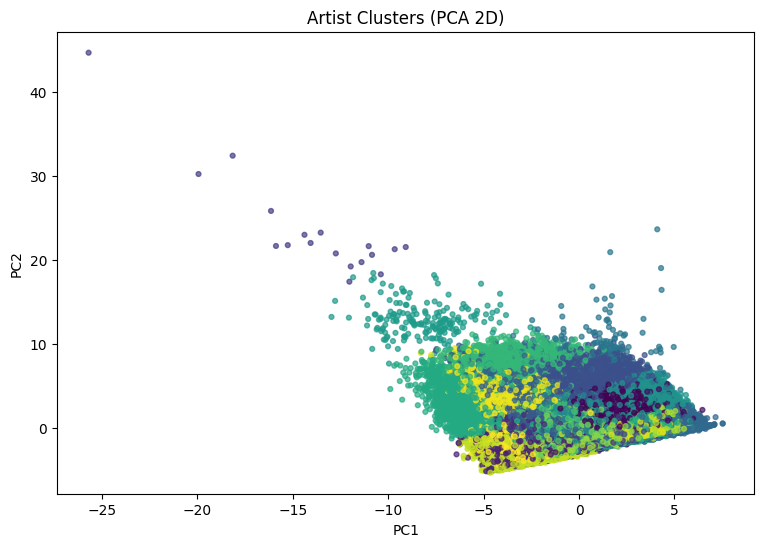

In [13]:
# Finales Modell auf vollständigem Datensatz trainieren
cluster_runner = ArtistClusteringRunner(
    k=int(best_cluster_cfg["k"]),
    seed=RANDOM_SEED,
    scale=bool(best_cluster_cfg["scale"]),
    pca_dim=int(best_cluster_cfg["pca_dim"]),
)
cluster_models, cluster_artifact, cluster_extra = cluster_runner.run(data.artist_df)

# Optional: Plot auf Sample
cluster_runner.plot_pca2(cluster_extra["X_used"], cluster_extra["labels"])


##  Embeddings & Track Similarity: Plausibilitäts-Checks

Track-Similarity ist in der Praxis oft **qualitativ** zu bewerten (klingen/fühlen sich die Nachbarn ähnlich an?).
Hier führen wir daher einen stabilen Check durch:

- Embedding einmal fitten
- Mehrere **gültige Track-Keys** auswählen
- Für jeden Key die Top-K ähnlichsten Tracks abrufen

Ziel: Sicherstellen, dass die Pipeline funktioniert, die Keys korrekt gematcht werden und die Ergebnisse plausibel sind.


In [14]:
sim_runner = TrackSimilarityRunner()
sim_models, sim_artifact = sim_runner.fit(data.track_df)

track_keys = data.track_df.index.to_numpy()
RNG = np.random.RandomState(RANDOM_SEED)
example_keys = RNG.choice(track_keys, size=5, replace=False)

# Spalte mit dem Track-Titel
title_col = "name"   # ggf. anpassen

def add_titles(similar_list):
    """similar_list: [(track_key, score), ...] -> [(track_key, title, score), ...]"""
    out = []
    for k, score in similar_list:
        # Titel per Index holen
        try:
            t = data.track_df.loc[k, title_col]
        except Exception:
            t = None
        out.append((k, t, float(score)))
    return out

examples_with_titles = {}

for key in example_keys:
    sims = sim_runner.get_similar(
        track_key=key,
        track_index=data.track_df.index,
        embeddings=sim_models["embeddings"],
        top_k=3

    )

    # Auch den Query-Track-Titel einschließen
    query_title = data.track_df.loc[key, title_col] if title_col in data.track_df.columns else None

    examples_with_titles[str(key)] = {
        "query": {"track_key": key, "title": query_title},
        "similar": add_titles(sims)
    }

examples_with_titles

{'206366': {'query': {'track_key': np.int64(206366), 'title': 'I Do'},
  'similar': [(139397, 'Open Up', 0.9918463850293483),
   (35302, 'Yorgunum Kaptan', 0.9898749481750196),
   (182381, '(Lovely Day For A) Parade', 0.9862959721866635)]},
 '257671': {'query': {'track_key': np.int64(257671),
   'title': 'Ennek A Kislánynak - Medley'},
  'similar': [(35202, 'Andere Zeiten', 0.9954536140651288),
   (104702, 'Rice, Beans', 0.9920353938967994),
   (258922, 'Midi Velocity', 0.9892536928469223)]},
 '199424': {'query': {'track_key': np.int64(199424),
   'title': "Hoedown's / Leather Britches / Sally Goodin' - Remastered"},
  'similar': [(151679,
    'Variations sur Casse-Noisette: V. Trepak',
    0.9932914607724468),
   (184766, 'Indian Boogie Woogie (Rhythmus In Indien)', 0.9886166860134288),
   (81301, 'Di Zilberne Khasene', 0.9883534550046844)]},
 '125920': {'query': {'track_key': np.int64(125920),
   'title': 'Mimaméta: Mimaméta'},
  'similar': [(77079, 'Average Fruit (MeLo-X GodMix)', 0

## Finalisierung: Best-Modelle retrainen & Artefakte speichern

Jetzt retrainen wir jedes Modell mit den **besten gefundenen Hyperparametern** und speichern:

- Modelle nach `PATHS.tuned_models_dir`
- Tuning-Report (Scores + Parameter + Artefakte) nach `PATHS.reports_dir_tuned`

Damit ist die Tuning-Runde reproduzierbar und die Ergebnisse sind sauber versioniert.


In [15]:
tuned_report = {}
# success_pct
pct_model, pct_metrics = pct_trainer.fit_eval(ds_pct,best_pct["best_params"])
save_joblib({"model": pct_model, "best_params": best_pct}, PATHS.tuned_models_dir / "success_pct_tuned.joblib")
tuned_report["success_pct"] = {"best": best_pct, "metrics": pct_metrics}

# success_residual
res_model, res_metrics = res_trainer.fit_eval(ds_res,best_res["best_params"])
save_joblib({"model": res_model, "best_params": best_res}, PATHS.tuned_models_dir / "success_residual_tuned.joblib")
tuned_report["success_residual"] = {"best": best_res, "metrics": res_metrics}

# hit
hit_model, hit_metrics, hit_thr = hit_trainer.fit_eval(ds_hit, params=best_hit["best_params"])
save_joblib({"model": hit_model, "threshold": hit_thr, "best_params": best_hit}, PATHS.tuned_models_dir / "hit_tuned.joblib")
tuned_report["hit"] = {"best": best_hit, "metrics": hit_metrics}

# mood (optional)
if best_mood is not None:
    thr = best_mood["best_params"].pop("threshold", 0.5)   # remove + keep value
    best_mood["best_threshold"] = thr                      # store separately
    mood_model, mood_metrics, mood_thresholds = mood_trainer.fit_eval(ds_mood, params=best_mood["best_params"])
    save_joblib({"model": mood_model,  "best_params": best_mood}, PATHS.tuned_models_dir / "mood_tuned.joblib")
    tuned_report["mood"] = {"best": best_mood, "metrics": mood_metrics}

# ranker (optional)
if "best_rank" in globals() and best_rank is not None:
    rank_model, rank_metrics = rank_trainer.fit_eval(ds_pct, params=best_rank["best_params"])
    save_joblib({"model": rank_model, "best_params": best_rank}, PATHS.tuned_models_dir / "ranker_tuned.joblib")
    tuned_report["ranker"] = {"best": best_rank, "metrics": rank_metrics}

# artist clustering (save fitted full model)
save_joblib({"models": cluster_models, "artifact": cluster_artifact, "best_cfg": best_cluster_cfg},
            PATHS.tuned_models_dir / "artist_clustering_tuned.joblib")
tuned_report["artist_clustering"] = {"best_cfg": best_cluster_cfg, "artifact": cluster_artifact}

# track similarity (save embedding)
save_joblib({"models": sim_models, "artifact": sim_artifact}, PATHS.tuned_models_dir / "track_similarity.joblib")
tuned_report["track_similarity"] = sim_artifact

# final tuned reporting json
tuned_report["run_config"] = {"seed": RANDOM_SEED, "allow_leaky_features": ALLOW_LEAKY_FEATURES}
save_json(tuned_report, PATHS.reports_dir_tuned / "tuned_metrics_report.json")

tuned_report.keys()


dict_keys(['success_pct', 'success_residual', 'hit', 'mood', 'ranker', 'artist_clustering', 'track_similarity', 'run_config'])